# Differential expression analysis
This notebook performs differential expression analysis using the real template experiment and simulated experiments, as a null set. 

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import random
import seaborn as sns
import rpy2.robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

sys.path.append("../")
from functions import utils

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "Rank_pathways",
                                           "init_config.tsv"))
params = utils.read_config(config_file)

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
num_runs = params['num_simulated']
project_id = params['project_id']

rerun_template = False
rerun_simulated = False

In [4]:
# Load real template experiment
template_data_file = os.path.join(
    local_dir,
    "recount2_template_data.tsv")

# Load metadata file with grouping assignments for samples
metadata_file = os.path.join(
    base_dir,
    "Rank_pathways",
    "data",
    "metadata",
    project_id+"_groups.tsv")

## Install R libraries

In [5]:
%%R
# Select 59
# Run one time
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("limma")
#BiocManager::install('EnhancedVolcano')
#devtools::install_github('kevinblighe/EnhancedVolcano')

NULL


In [6]:
%%R
library('limma')

### Get differentially expressed genes from template experiment

In [7]:
%%R -i metadata_file -i project_id -i template_data_file -i local_dir -i rerun_template

source('../functions/DE_analysis.R')

out_file <- paste(local_dir,
                  "DE_stats/DE_stats_template_data_",
                  project_id,
                  "_real.txt",
                  sep="")

if (rerun_template){
    get_DE_stats(metadata_file,
                 project_id, 
                 template_data_file,
                 "template",
                 local_dir,
                 "real")
    }

### Check signal strength

In [8]:
# Load association statistics for template experiment
template_DE_stats_file = os.path.join(
    local_dir,
    "DE_stats",
    "DE_stats_template_data_"+project_id+"_real.txt")

In [9]:
template_DE_stats = pd.read_csv(
    template_DE_stats_file,
    header=0,
    sep='\t',
    index_col=0)

template_DEGs = template_DE_stats[(template_DE_stats['adj.P.Val']<0.001) & 
                                  (template_DE_stats['logFC'].abs()>1)]
print(template_DEGs.shape)
template_DEGs.head(10)

(2623, 6)


,logFC,AveExpr,t,P.Value,adj.P.Val,B
ENSG00000234617.1,-4.958371,5.900715,-20.976337,3.299743e-16,1.227561e-11,27.218967
ENSG00000123243.14,-3.703407,3.134390,-20.733381,4.230270e-16,1.227561e-11,26.975439
ENSG00000149428.18,15.428655,22.573867,17.878306,9.708073e-15,1.878091e-10,23.879618
ENSG00000141448.8,-10.775702,9.814635,-17.379226,1.755945e-14,2.289616e-10,23.289582
ENSG00000235750.9,-16.443337,16.758748,-17.081627,2.518009e-14,2.289616e-10,22.930088
ENSG00000168994.13,-20.778738,22.482341,-17.040337,2.648275e-14,2.289616e-10,22.879747
ENSG00000077943.7,-7.371572,6.564904,-16.980417,2.849932e-14,2.289616e-10,22.806490
ENSG00000266283.1,-9.702790,8.724009,-16.897408,3.156078e-14,2.289616e-10,22.704605
ENSG00000224660.1,-14.343534,17.211195,-16.510961,5.104370e-14,3.291581e-10,22.224082
ENSG00000135604.9,-23.845923,16.245391,-16.396267,5.898151e-14,3.423110e-10,22.079468


In [10]:
%%R
library(EnhancedVolcano)

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: ggrepel

  warnings.warn(x, RRuntimeWarning)


In [11]:
%%R -i project_id -i template_DE_stats_file -i local_dir

source('../functions/DE_analysis.R')

create_volcano(template_DE_stats_file,
               project_id,
               "adj.P.Val",
               local_dir)

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Saving 6.67 x 6.67 in image

  warnings.warn(x, RRuntimeWarning)


### Get differentially expressed genes from each simulated experiment

In [12]:
%%R -i metadata_file -i project_id -i base_dir -i local_dir -i num_runs -i rerun_simulated -o num_sign_DEGs_simulated

source('../functions/DE_analysis.R')

num_sign_DEGs_simulated <- c()

for (i in 0:(num_runs-1)){
    simulated_data_file <- paste(local_dir, 
                                 "pseudo_experiment/selected_simulated_data_",
                                 project_id,
                                 "_", 
                                 i,
                                 ".txt",
                                 sep="")
    out_file <- paste(local_dir, 
                      "DE_stats/DE_stats_simulated_data_",
                      project_id,
                      "_",
                      i,
                      ".txt", 
                      sep="")
    
    if (rerun_simulated){
        run_output <- get_DE_stats(metadata_file,
                                   project_id, 
                                   simulated_data_file,
                                   "simulated",
                                   local_dir,
                                   i)
        num_sign_DEGs_simulated <- c(num_sign_DEGs_simulated, run_output)
    } else {
        # Read in DE stats data
        DE_stats_data <- as.data.frame(read.table(out_file, sep="\t", header=TRUE, row.names=1))
        
        # Get number of genes that exceed threshold
        threshold <- 0.001
        sign_DEGs <- DE_stats_data[DE_stats_data[,'adj.P.Val']<threshold & abs(DE_stats_data[,'logFC'])>1,]
        
        num_sign_DEGs <- nrow(sign_DEGs)
        
        num_sign_DEGs_simulated <- c(num_sign_DEGs_simulated, num_sign_DEGs)
    }
}

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


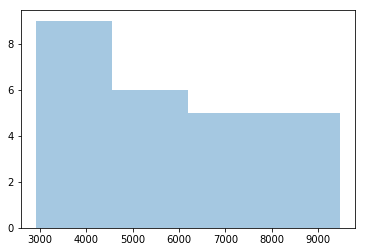

In [13]:
# Plot distribution of differentially expressed genes for simulated experiments
sns.distplot(num_sign_DEGs_simulated,
            kde=False)

**Observation:** All simulated experiments found 0 DEGs using adjusted p-value cutoff of <5%

**Check**

As a check, we compared the number of DEGs identified here versus what was reported in the [Kim et. al. publication](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3566005/#pone.0055596.s008), which found:
* Four conditions needed to be met for the genes to be selected as differentially expressed genes (DEGs): (i) overall differential expression from the edgeR analysis with FDR < 0.001, (ii) a minimum of 3 patients with significant differential expression, as tested by edgeR for individual differential expression with FDR < 0.01, (iii) consistent up/down regulation among different patients representing more than a two-fold change, and (iv) significant expression in at least 3 patients to remove genes with large fold changes within the noise expression level (FVKM>2 in either normal or tumor tissue). 
* In total, we selected 1459 genes (543 upregulated and 916 downregulated in tumors) differentially expressed in female NSCLC never-smoker patients
* Used edgeR to identify DEGs

By comparison:
* Our study found 2623 DEGs using limma and applying FDR < 0.001 
* Spot checking the genes identified with their list of DEGs from S2, we found the some of the same genes and FC direction was consistent. 
* Currently we are normalizing read counts [downloaded from recount2](https://bioconductor.org/packages/devel/bioc/vignettes/recount/inst/doc/recount-quickstart.html) using RPKM and piping that through limma to identify DEG (this is legacy code from when we expected microarray input instead of RNA-seq)

## Get statistics for differential expression analysis

In [14]:
col_to_rank = 't'

In [15]:
# Get ranks of template experiment

# If ranking by p-value or adjusted p-value then high rank = low value
if col_to_rank in ['P.Value', 'adj.P.Val']:
    template_DE_stats['ranking'] = template_DE_stats[col_to_rank].rank(ascending = False)
    template_DE_stats = template_DE_stats.sort_values(by=col_to_rank, ascending=True)

# If ranking by logFC then high rank = high abs(value)
elif col_to_rank in ['logFC','t']:
    template_DE_stats['ranking'] = template_DE_stats[col_to_rank].abs().rank(ascending = True)
    template_DE_stats = template_DE_stats.sort_values(by=col_to_rank, ascending=False)

# If ranking by Z-score then high rank = high value
else:
    template_DE_stats['ranking'] = template_DE_stats[col_to_rank].rank(ascending = True)
    template_DE_stats = template_DE_stats.sort_values(by=col_to_rank, ascending=False)

template_DE_stats.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B,ranking
ENSG00000149428.18,15.428655,22.573867,17.878306,9.708073e-15,1.878091e-10,23.879618,58035.0
ENSG00000185624.14,78.582114,133.719454,15.503336,1.873262e-13,7.765607e-10,20.920986,58024.0
ENSG00000165898.13,2.590360,4.068998,15.024150,3.564669e-13,1.216957e-09,20.274369,58021.0
ENSG00000143320.8,55.664129,32.588884,14.616596,6.245090e-13,1.720768e-09,19.709955,58018.0
ENSG00000059573.8,11.776286,13.762430,14.498806,7.361359e-13,1.857527e-09,19.544277,58015.0


In [17]:
# Concatenate simulated experiments
simulated_DE_stats_all = pd.DataFrame()
for i in range(num_runs):
    simulated_DE_stats_file = os.path.join(
        local_dir, 
        "DE_stats",
        "DE_stats_simulated_data_"+project_id+"_"+str(i)+".txt")
    
    #Read results
    simulated_DE_stats = pd.read_csv(
        simulated_DE_stats_file,
        header=0,
        sep='\t',
        index_col=0)
    
    simulated_DE_stats.reset_index(inplace=True)
    
    # Add ranks of simulated experiment
    # If ranking by p-value or adjusted p-value then high rank = low value
    if col_to_rank in ['P.Value', 'adj.P.Val']:
        simulated_DE_stats['ranking'] = simulated_DE_stats[col_to_rank].rank(ascending = False)
        simulated_DE_stats = simulated_DE_stats.sort_values(by=col_to_rank, ascending=True)

    # If ranking by logFC then high rank = high abs(value)
    elif col_to_rank in ['logFC','t']:
        simulated_DE_stats['ranking'] = simulated_DE_stats[col_to_rank].abs().rank(ascending = True)
        simulated_DE_stats = simulated_DE_stats.sort_values(by=col_to_rank, ascending=False)

    # If ranking by Z-score then high rank = high value
    else:
        simulated_DE_stats['ranking'] = simulated_DE_stats[col_to_rank].rank(ascending = True)
        simulated_DE_stats = simulated_DE_stats.sort_values(by=col_to_rank, ascending=False)
    
    # Concatenate df
    simulated_DE_stats_all = pd.concat([simulated_DE_stats_all,
                                       simulated_DE_stats])
    
print(simulated_DE_stats_all.shape)
simulated_DE_stats_all.head()

(1450925, 8)


,index,logFC,AveExpr,t,P.Value,adj.P.Val,B,ranking
14,ENSG00000146909.7,0.455583,3.542625,19.317802,1.676239e-15,6.485594e-12,25.590287,58023.0
15,ENSG00000184428.12,0.669833,3.883250,19.150545,2.016684e-15,7.126526e-12,25.403596,58022.0
19,ENSG00000137106.17,0.507667,7.483917,18.105418,6.621592e-15,1.921487e-11,24.201230,58018.0
23,ENSG00000226648.1,0.573583,3.266292,17.875895,8.666800e-15,2.095813e-11,23.928563,58014.0
24,ENSG00000132361.16,2.778917,16.341875,17.827647,9.174839e-15,2.129921e-11,23.870836,58013.0


In [21]:
if col_to_rank == "adj.P.Val":
    simulated_DE_summary_stats = simulated_DE_stats_all.groupby(['index'])[[col_to_rank, 'adj.P.Val', 'ranking']].agg({
        col_to_rank:['mean', 'std','count', 'median'],
        'ranking':['median']
    })
else:
    simulated_DE_summary_stats = simulated_DE_stats_all.groupby(['index'])[[col_to_rank, 'adj.P.Val', 'ranking']].agg({
        col_to_rank:['mean', 'std','count'],
        'adj.P.Val':['median'],
        'ranking':['median']
    })
simulated_DE_summary_stats.head()

t                     adj.P.Val  ranking
                         mean       std count        median   median
index                                                               
ENSG00000000003.14   4.235266  3.123622    25  8.034397e-04  35746.0
ENSG00000000005.5   -2.756247  4.111687    25  1.205394e-02  24689.0
ENSG00000000419.12   8.807888  3.455144    25  9.772783e-08  53139.0
ENSG00000000457.13   5.566738  4.768113    25  3.487752e-06  47172.0
ENSG00000000460.16  10.652649  3.172532    25  1.755356e-08  55366.0

In [22]:
# Merge template statistics with simulated statistics
template_simulated_DE_stats = template_DE_stats.merge(simulated_DE_summary_stats, 
                                                     left_index=True,
                                                     right_index=True)
print(template_simulated_DE_stats.shape)
template_simulated_DE_stats.head()

(58037, 12)


/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,logFC,AveExpr,t,P.Value,adj.P.Val,B,ranking,"(t, mean)","(t, std)","(t, count)","(adj.P.Val, median)","(ranking, median)"
ENSG00000149428.18,15.428655,22.573867,17.878306,9.708073e-15,1.878091e-10,23.879618,58035.0,8.589201,6.643574,25,1.522475e-07,50804.0
ENSG00000185624.14,78.582114,133.719454,15.503336,1.873262e-13,7.765607e-10,20.920986,58024.0,1.895743,4.269302,25,3.667132e-03,28321.0
ENSG00000165898.13,2.590360,4.068998,15.024150,3.564669e-13,1.216957e-09,20.274369,58021.0,10.370210,2.944204,25,1.624679e-08,55555.0
ENSG00000143320.8,55.664129,32.588884,14.616596,6.245090e-13,1.720768e-09,19.709955,58018.0,3.057282,2.246357,25,6.292967e-03,29291.0
ENSG00000059573.8,11.776286,13.762430,14.498806,7.361359e-13,1.857527e-09,19.544277,58015.0,9.340935,4.708125,25,2.526474e-07,54537.0


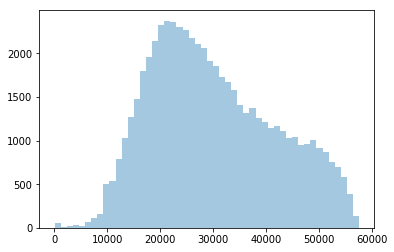

In [29]:
sns.distplot(template_simulated_DE_stats[('ranking','median')].values, kde=False)

In [24]:
# Parse columns
median_pval_simulated = template_simulated_DE_stats[('adj.P.Val','median')]
median_rank_simulated = template_simulated_DE_stats[('ranking','median')]
mean_test_simulated = template_simulated_DE_stats[(col_to_rank,'mean')]
std_test_simulated = template_simulated_DE_stats[(col_to_rank,'std')]
count_simulated = template_simulated_DE_stats[(col_to_rank,'count')]

In [25]:
summary = pd.DataFrame(data={'Gene ID': template_simulated_DE_stats.index,
                             'Adj P-value (Real)': template_simulated_DE_stats['adj.P.Val'],
                             'Rank (Real)': template_simulated_DE_stats['ranking'],
                             'Test statistic (Real)': template_simulated_DE_stats[col_to_rank],
                             'Median adj p-value (simulated)': median_pval_simulated ,
                             'Median rank (simulated)': median_rank_simulated ,
                             'Mean test statistic (simulated)': mean_test_simulated ,
                             'Std deviation (simulated)': std_test_simulated,
                             'Number of experiments (simulated)': count_simulated
                            }
                      )
summary['Z score'] = (summary['Test statistic (Real)'] - summary['Mean test statistic (simulated)'])/summary['Std deviation (simulated)']
summary.head()

,Gene ID,Adj P-value (Real),Rank (Real),Test statistic (Real),Median adj p-value (simulated),Median rank (simulated),Mean test statistic (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
ENSG00000149428.18,ENSG00000149428.18,1.878091e-10,58035.0,17.878306,1.522475e-07,50804.0,8.589201,6.643574,25,1.398209
ENSG00000185624.14,ENSG00000185624.14,7.765607e-10,58024.0,15.503336,3.667132e-03,28321.0,1.895743,4.269302,25,3.187311
ENSG00000165898.13,ENSG00000165898.13,1.216957e-09,58021.0,15.024150,1.624679e-08,55555.0,10.370210,2.944204,25,1.580713
ENSG00000143320.8,ENSG00000143320.8,1.720768e-09,58018.0,14.616596,6.292967e-03,29291.0,3.057282,2.246357,25,5.145804
ENSG00000059573.8,ENSG00000059573.8,1.857527e-09,58015.0,14.498806,2.526474e-07,54537.0,9.340935,4.708125,25,1.095525


In [26]:
summary.sort_values(by="Z score", ascending=False)

,Gene ID,Adj P-value (Real),Rank (Real),Test statistic (Real),Median adj p-value (simulated),Median rank (simulated),Mean test statistic (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
ENSG00000143320.8,ENSG00000143320.8,1.720768e-09,58018.0,14.616596,6.292967e-03,29291.0,3.057282,2.246357,25,5.145804
ENSG00000062038.13,ENSG00000062038.13,4.085926e-09,57999.0,13.583345,1.662156e-03,36027.0,4.216646,2.006417,25,4.668372
ENSG00000278374.1,ENSG00000278374.1,8.157912e-02,43117.0,2.483369,1.466338e-06,46741.0,-7.088250,2.287895,25,4.183592
ENSG00000100196.10,ENSG00000100196.10,1.134340e-07,57903.0,10.748633,1.905740e-01,14319.0,1.227717,2.471911,25,3.851641
ENSG00000211679.2,ENSG00000211679.2,6.460346e-03,51630.0,3.920759,2.470961e-08,55568.0,-10.658360,3.873448,25,3.763861
ENSG00000223534.1,ENSG00000223534.1,9.664534e-01,9359.0,-0.242471,2.409198e-09,55431.0,-11.256017,2.934998,25,3.752489
ENSG00000171812.11,ENSG00000171812.11,1.111093e-01,41204.0,2.283679,2.042333e-07,50749.0,-8.640999,2.917079,25,3.745074
ENSG00000204257.14,ENSG00000204257.14,1.602879e-01,38718.0,2.039716,3.508539e-07,51525.0,-8.203535,2.770244,25,3.697599
ENSG00000139044.10,ENSG00000139044.10,1.144612e-05,57074.0,7.397428,2.380984e-01,12063.0,0.471991,1.881808,25,3.680203
ENSG00000258904.1,ENSG00000258904.1,1.313815e-05,57027.0,7.312638,4.532528e-04,34883.0,-4.882278,3.330150,25,3.661971


In [27]:
# Save file
summary_file = os.path.join(
        local_dir, 
        "gene_summary_table.tsv")

summary.to_csv(summary_file, float_format='%.5f', sep='\t')